## Dependencies

In [1]:
import json, warnings, shutil
from jigsaw_utility_scripts import *
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [2]:
strategy = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [3]:
database_base_path = '/kaggle/input/jigsaw-dataset-split-toxic-roberta-base-192/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/jigsaw-dataset-split-toxic-roberta-base-192/fold_1.tar.gz
!tar -xvf /kaggle/input/jigsaw-dataset-split-toxic-roberta-base-192/fold_2.tar.gz
!tar -xvf /kaggle/input/jigsaw-dataset-split-toxic-roberta-base-192/fold_3.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-toxic-roberta-base-192/fold_4.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-toxic-roberta-base-192/fold_5.tar.gz

,index,comment_text,toxic,fold_1,fold_2,fold_3,fold_4,fold_5
0,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,train,train,validation,train,train
1,12,Hey... what is it..\n@ | talk .\nWhat is it......,1,train,train,train,train,validation
2,16,"Bye! \n\nDon't look, come or think of comming ...",1,train,train,train,validation,train
3,42,You are gay or antisemmitian? \n\nArchangel WH...,1,validation,train,train,train,train
4,43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,train,validation,train,train,train


fold_1/
fold_1/y_valid.npy
fold_1/y_train.npy
fold_1/x_train.npy
fold_1/x_valid.npy
fold_2/
fold_2/y_valid.npy
fold_2/y_train.npy
fold_2/x_train.npy
fold_2/x_valid.npy
fold_3/
fold_3/y_valid.npy
fold_3/y_train.npy
fold_3/x_train.npy
fold_3/x_valid.npy


# Model parameters

In [4]:
base_path = '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/'

config = {
  "MAX_LEN": 192,
  "BATCH_SIZE": 16 * strategy.num_replicas_in_sync,
  "EPOCHS": 3,
  "LEARNING_RATE": 1e-5, 
  "ES_PATIENCE": 1,
  "N_FOLDS": 3,
  "base_model_path": base_path + 'tf-xlm-roberta-base-tf_model.h5',
  "config_path": base_path + 'xlm-roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Model

In [5]:
module_config = XLMRobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    base_model = TFXLMRobertaModel.from_pretrained(config['base_model_path'], config=module_config)
    sequence_output = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    last_state = sequence_output[0]
    cls_token = last_state[:, 0, :]
    
    output = layers.Dense(1, activation='sigmoid', name='output')(cls_token)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizers.Adam(lr=config['LEARNING_RATE']), 
                  loss=losses.BinaryCrossentropy(), 
                  metrics=[metrics.BinaryAccuracy(), metrics.AUC()])
    
    return model

# Train

In [6]:
history_list = []

for n_fold in range(config['N_FOLDS']):
    print('\nFOLD: %d' % (n_fold+1))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold+1)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[0] // config['BATCH_SIZE']

    ### Delete data dir
    shutil.rmtree(base_data_path)

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold+1)
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True, verbose=1)
    
    with strategy.scope():
        model = model_fn(config['MAX_LEN'])
        history = model.fit(list(x_train), y_train,
                        validation_data=(list(x_valid), y_valid),
                        callbacks=[checkpoint, es],
                        epochs=config['EPOCHS'], 
                        batch_size=config['BATCH_SIZE'],
                        steps_per_epoch=step_size,
                        verbose=2).history
        
    history_list.append(history)
    
    # Make predictions
    train_preds = model.predict(list(x_train))
    valid_preds = model.predict(list(x_valid))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'train', 'pred_%d' % (n_fold+1)] = np.round(train_preds)
    k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'validation', 'pred_%d' % (n_fold+1)] = np.round(valid_preds)


FOLD: 1
Train on 97107 samples, validate on 24277 samples
Epoch 1/3

Epoch 00001: val_loss improved from inf to 0.13868, saving model to model_fold_1.h5
97107/97107 - 314s - loss: 0.1748 - binary_accuracy: 0.9266 - auc: 0.9656 - val_loss: 0.1387 - val_binary_accuracy: 0.9433 - val_auc: 0.9809
Epoch 2/3

Epoch 00002: val_loss improved from 0.13868 to 0.13150, saving model to model_fold_1.h5
97107/97107 - 178s - loss: 0.1273 - binary_accuracy: 0.9457 - auc: 0.9819 - val_loss: 0.1315 - val_binary_accuracy: 0.9455 - val_auc: 0.9827
Epoch 3/3

Epoch 00003: val_loss improved from 0.13150 to 0.12979, saving model to model_fold_1.h5
97107/97107 - 179s - loss: 0.1123 - binary_accuracy: 0.9530 - auc: 0.9856 - val_loss: 0.1298 - val_binary_accuracy: 0.9456 - val_auc: 0.9824

FOLD: 2
Train on 97107 samples, validate on 24277 samples
Epoch 1/3

Epoch 00001: val_loss improved from inf to 0.14106, saving model to model_fold_2.h5
97107/97107 - 285s - loss: 0.1907 - binary_accuracy: 0.9194 - auc_1: 0.

## Model loss graph

Fold: 1


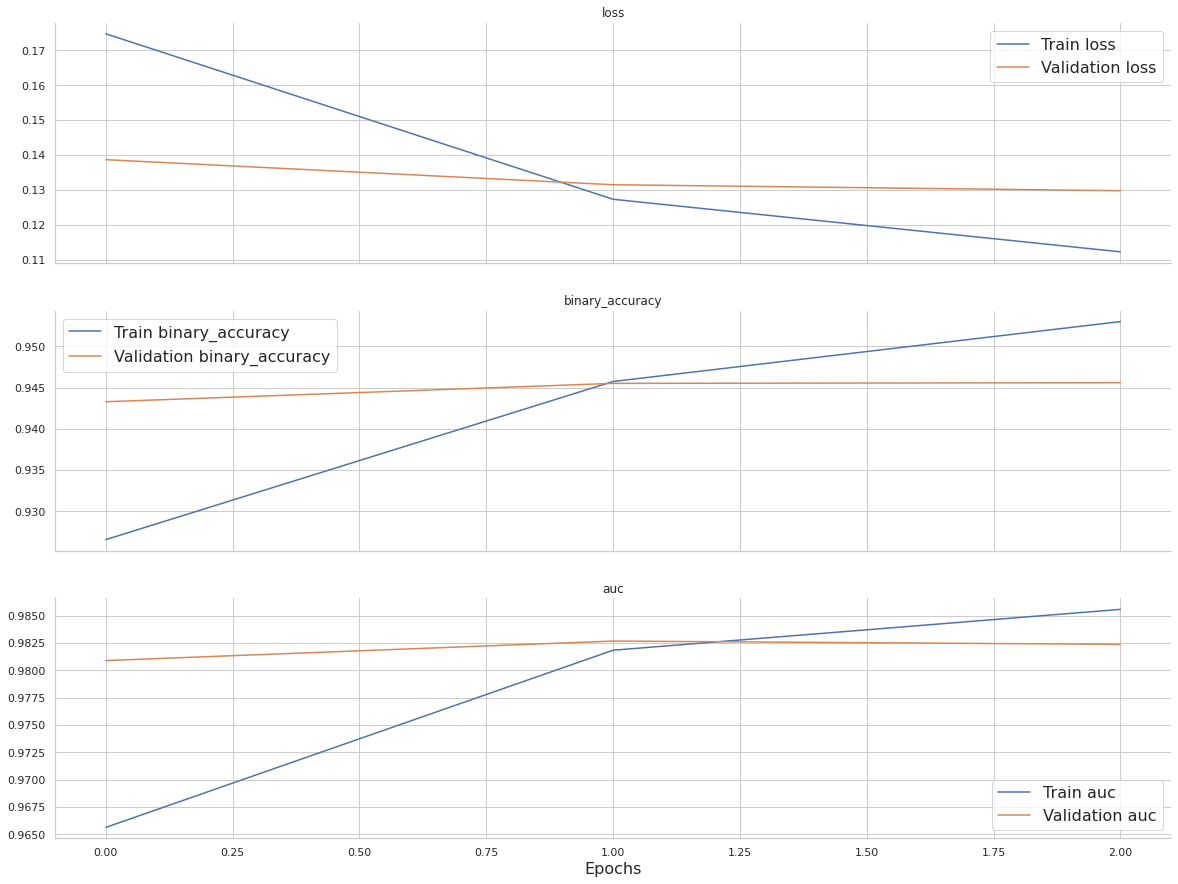

Fold: 2


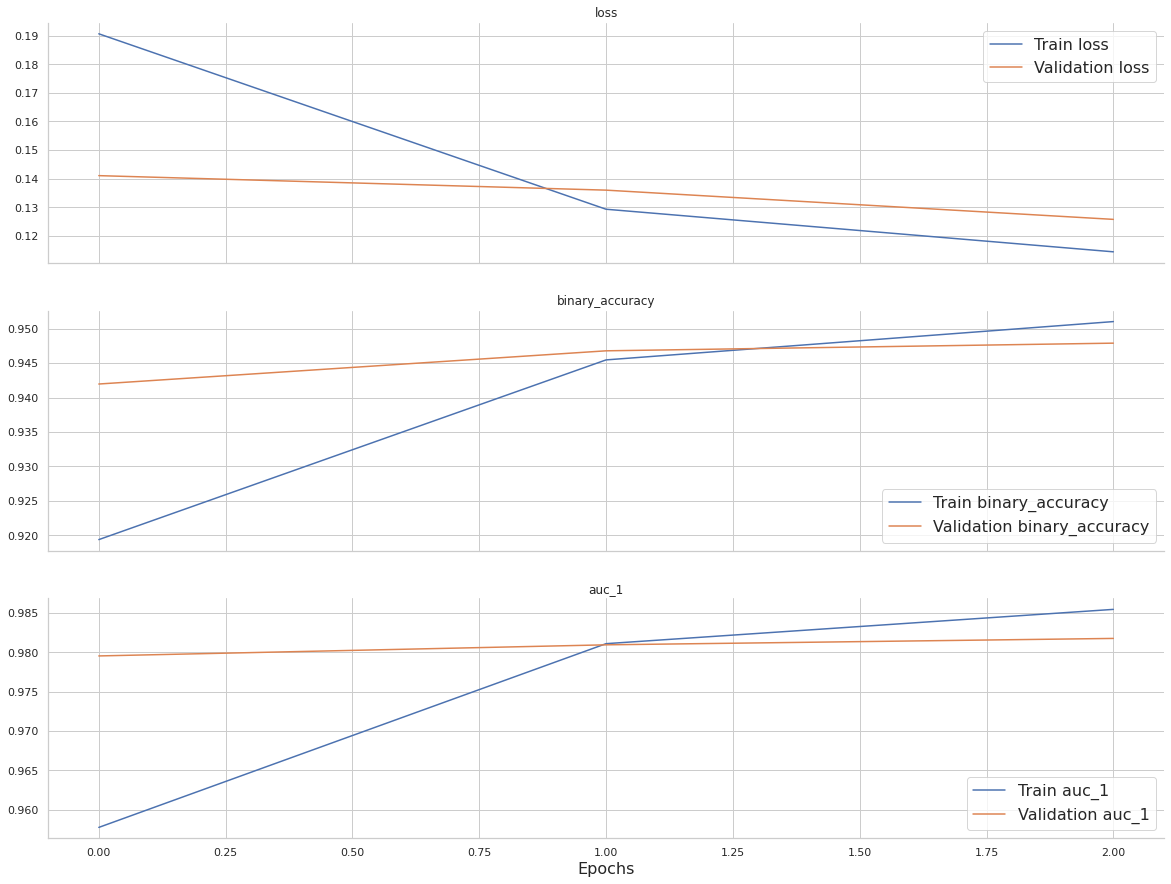

Fold: 3


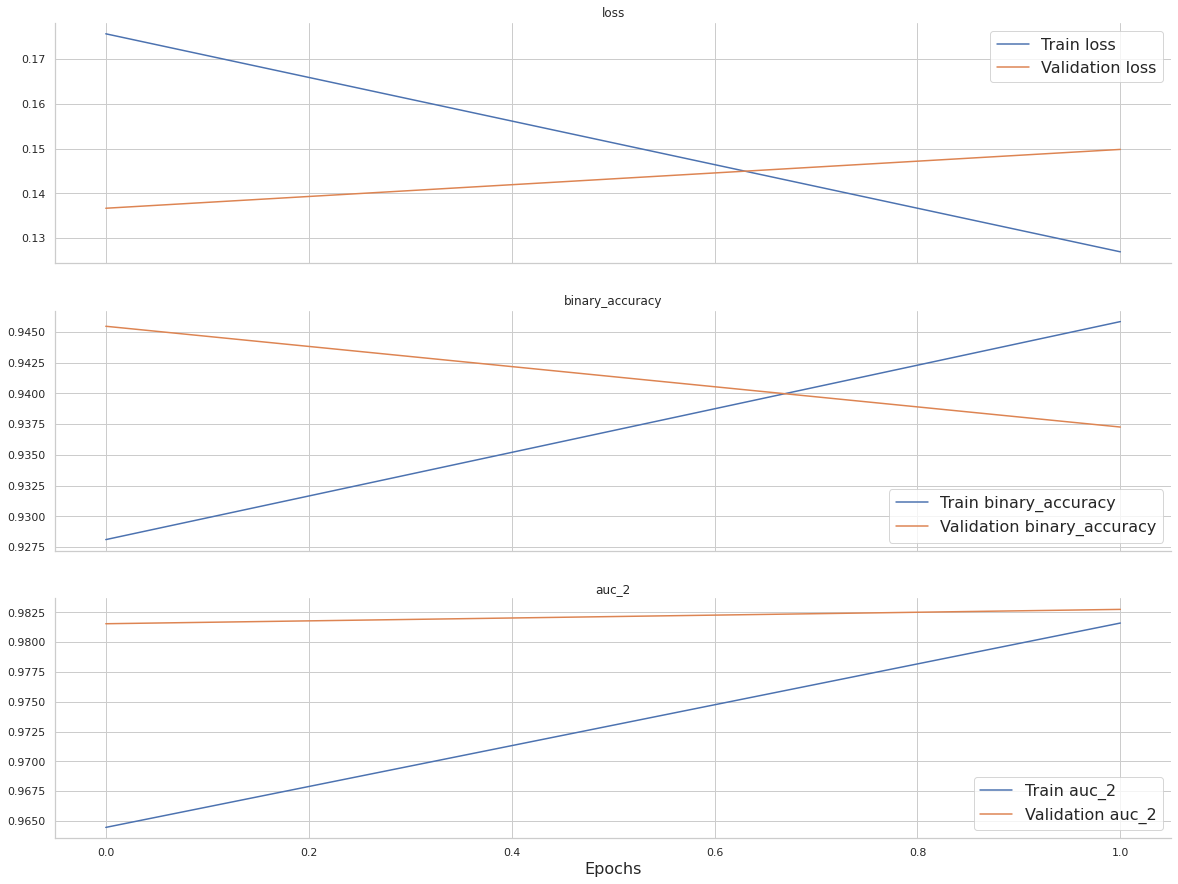

In [7]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [8]:
display(evaluate_model(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.932915,0.907406,0.0255092,0.951409,0.916569,0.939662,0.90735,0.907675,0.898297
Accuracy,0.960188,0.946369,0.0138193,0.966202,0.945669,0.964338,0.947893,0.950024,0.945545
Precision,0.883895,0.848707,0.0351884,0.885205,0.828813,0.896582,0.85738,0.869899,0.859927
Recall,0.890805,0.847245,0.04356,0.928567,0.871639,0.901561,0.844751,0.842287,0.825345
F1-score,0.887101,0.847662,0.0394386,0.906368,0.849687,0.899064,0.851019,0.85587,0.842281
Support,17107,4277,12830,17107,4277,17107,4277,17107,4277


# Confusion matrix

Fold: 1


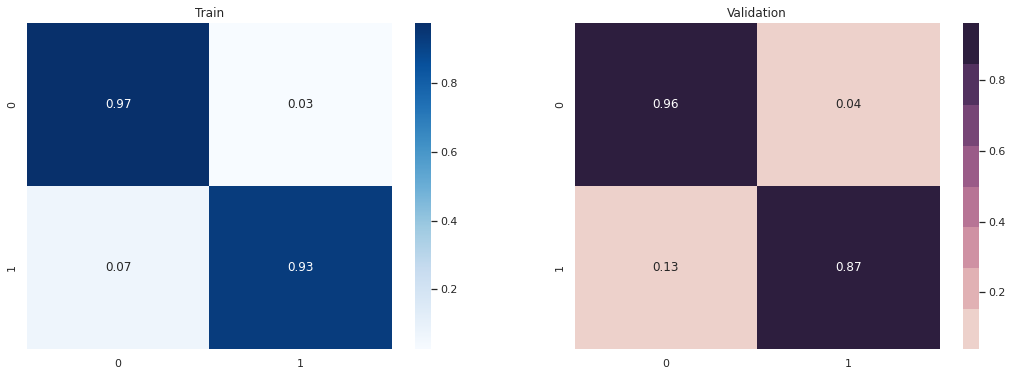

Fold: 2


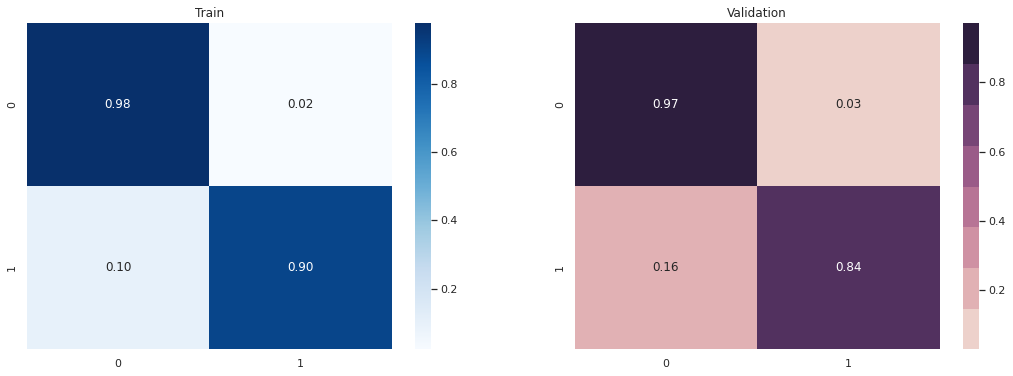

Fold: 3


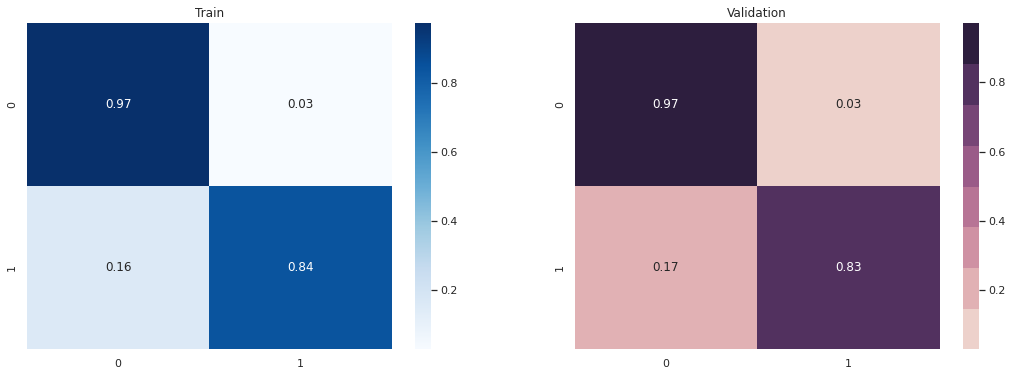

In [9]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    train_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'train']
    validation_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'validation'] 
    plot_confusion_matrix(train_set['toxic'], train_set['pred_%d' % (n_fold+1)], 
                          validation_set['toxic'], validation_set['pred_%d' % (n_fold+1)])

# Visualize predictions

In [10]:
display(k_fold[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(15))

,comment_text,toxic,pred_1,pred_2,pred_3
0,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1.0,1.0,1.0
1,Hey... what is it..\n@ | talk .\nWhat is it......,1,1.0,0.0,0.0
2,"Bye! \n\nDon't look, come or think of comming ...",1,1.0,1.0,0.0
3,You are gay or antisemmitian? \n\nArchangel WH...,1,1.0,1.0,1.0
4,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,1.0,1.0,1.0
5,I'm Sorry \n\nI'm sorry I screwed around with ...,1,0.0,0.0,0.0
6,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,1.0,1.0,1.0
7,Stupid peace of shit stop deleting my stuff as...,1,1.0,1.0,1.0
8,=Tony Sidaway is obviously a fistfuckee. He lo...,1,1.0,1.0,1.0
9,My Band Page's deletion. You thought I was gon...,1,1.0,1.0,1.0
